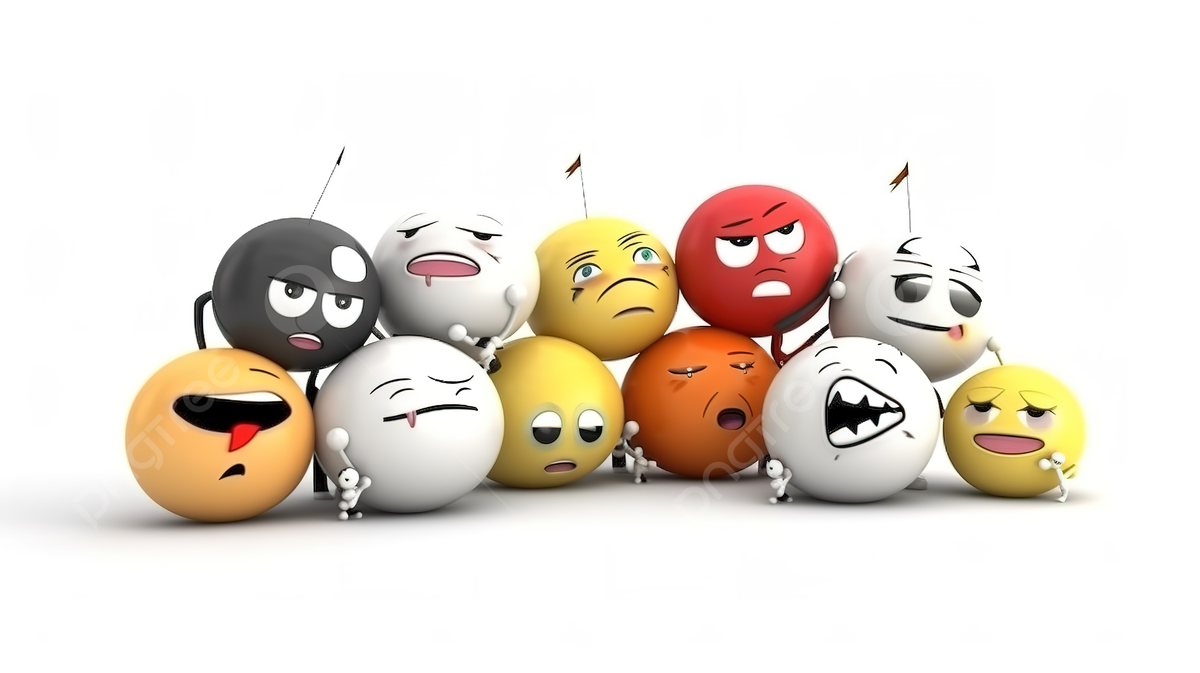

<html>
<head>
  <style>
    body {
      font-family: sans-serif;
      line-height: 1.5;
      padding: 10px;
    }

    h2 {
      font-size: 1.2em;
      margin-bottom: 0.5em;
    }

    .description {
      font-style: italic;
      color: #888;
    }

    .example {
      font-weight: bold;
      margin-bottom: 5px;
    }
  </style>
</head>
<body>
    <p style='font-size: 2.5em; margin-bottom: 0.5em;'>Data Description</p>

  <p>The dataset contains a collection of text data (e.g., tweets, comments, messages) paired with corresponding emotion labels. Labels typically represent a range of emotions such as joy, sadness, anger, fear, surprise, or love.</p>
  <p style='font-size: 2.5em; margin-bottom: 0.5em;'>Model</p>
  <p>This notebook explores the development of an emotion classification model using NLP techniques. This model aims to:</p>
  <ul>
    <li>Classify the mood associated with text content.</li>
  </ul>

<p style='font-size: 2.5em; margin-bottom: 0.5em;'>Features:</p>
  <ul>
    <li><strong>text:</strong> The actual text content of the tweet or comment.</li>
    <li><strong>Emotion:</strong> string label indicating whether the tweet is about a joy, sadness, anger, fear, surprise, or love.</li>
  </ul>

  <p><strong>Size:</strong> 20,000</p>
</body>
</html>

# <a id="Import"></a>
# <p style="background-color: #FFE300; font-family: 'Copperplate'; color:#493323; font-size:140%; text-align:center; border-radius:1000px 10px;"> Importing Libraries</p> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
import spacy
nlp=spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad,Adamax
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# <a id="Import"></a>
# <p style="background-color: #FFE300; font-family: 'Copperplate'; color:#493323; font-size:140%; text-align:center; border-radius:1000px 10px;"> EDA & Visualization </p> 

In [2]:
train=pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt',names=['Text', 'Emotion'], sep=';')
test=pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt',names=['Text', 'Emotion'], sep=';')
val=pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt',names=['Text', 'Emotion'], sep=';')
data=pd.concat([train,test,val])

In [3]:
data.reset_index(inplace=True,drop=True)

In [4]:
data.sample(10)

,Text,Emotion
8330,i feel nevertheless not convinced which g is t...,joy
14142,i contend that the acceptance is a bow to the ...,sadness
4100,i am fucking it up with my pattern of wanting ...,love
386,i feel energized and curious again about life ...,surprise
1788,i was insane not liking someone else to do all...,joy
12858,i have quite amount of friends here but yet ho...,sadness
14186,i know how that feels hermione said in a surpr...,love
2767,i cry about feeling shitty i cry because dad m...,sadness
5748,i feel so embarrassed of myself for even havin...,sadness
12857,i have only a few short weeks here and im feel...,sadness


In [5]:
data.shape

(20000, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     20000 non-null  object
 1   Emotion  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [7]:
data.describe(include='object')

,Text,Emotion
count,20000,20000
unique,19948,6
top,i feel a remembrance of the strange by justin ...,joy
freq,2,6761


In [8]:
colors = ['#C0C78C', '#245953', '#E49393','#3357FF', '#FF33A6','red']

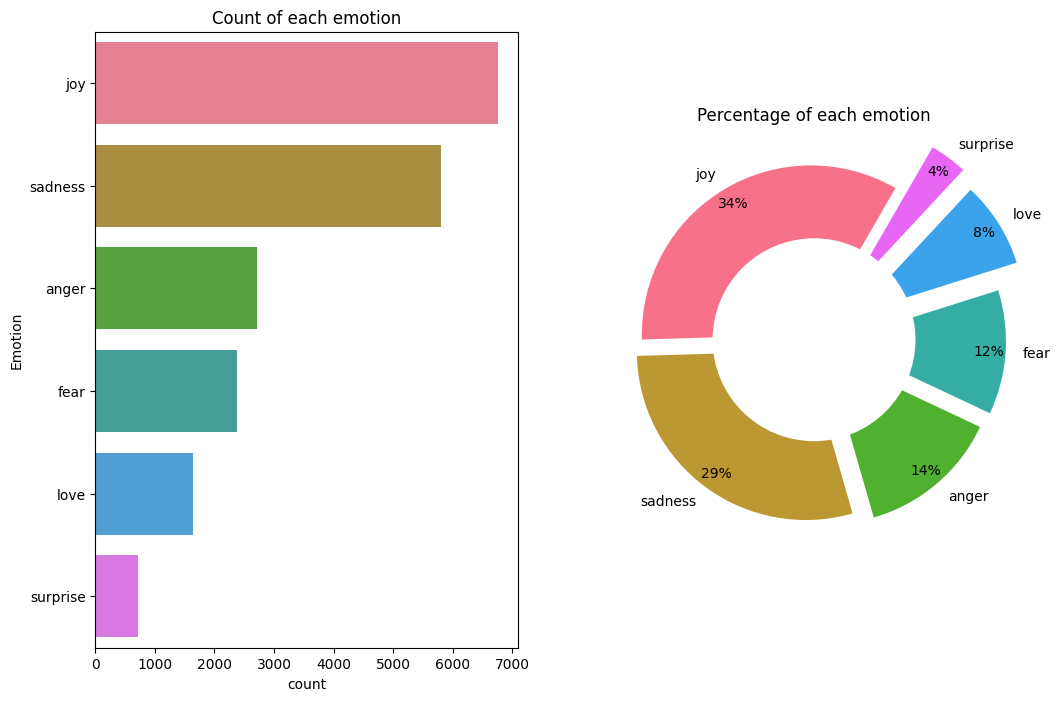

In [9]:
col = 'Emotion'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

labels = list(data[col].value_counts().index[:10])
sizes = data[col].value_counts().values[:10]

colors = sns.color_palette("husl", len(labels))

explode = list((np.array(sizes) / sum(sizes)))[::-1]

ax2.pie(sizes, explode=explode, startangle=60, labels=labels, autopct='%1.0f%%',
        pctdistance=0.9, colors=colors)
ax2.add_artist(plt.Circle((0,0), 0.6, fc='white'))

sns.countplot(y=col, data=data, ax=ax1, palette=colors,
              order=data[col].value_counts().index[:10])

ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")

plt.show()


In [10]:
data['len']=data['Text'].apply(len)

/tmp/ipykernel_17/1869317518.py:5: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.kdeplot(x=data['len'], hue=data['Emotion'], ax=ax[0], palette=colors)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` i

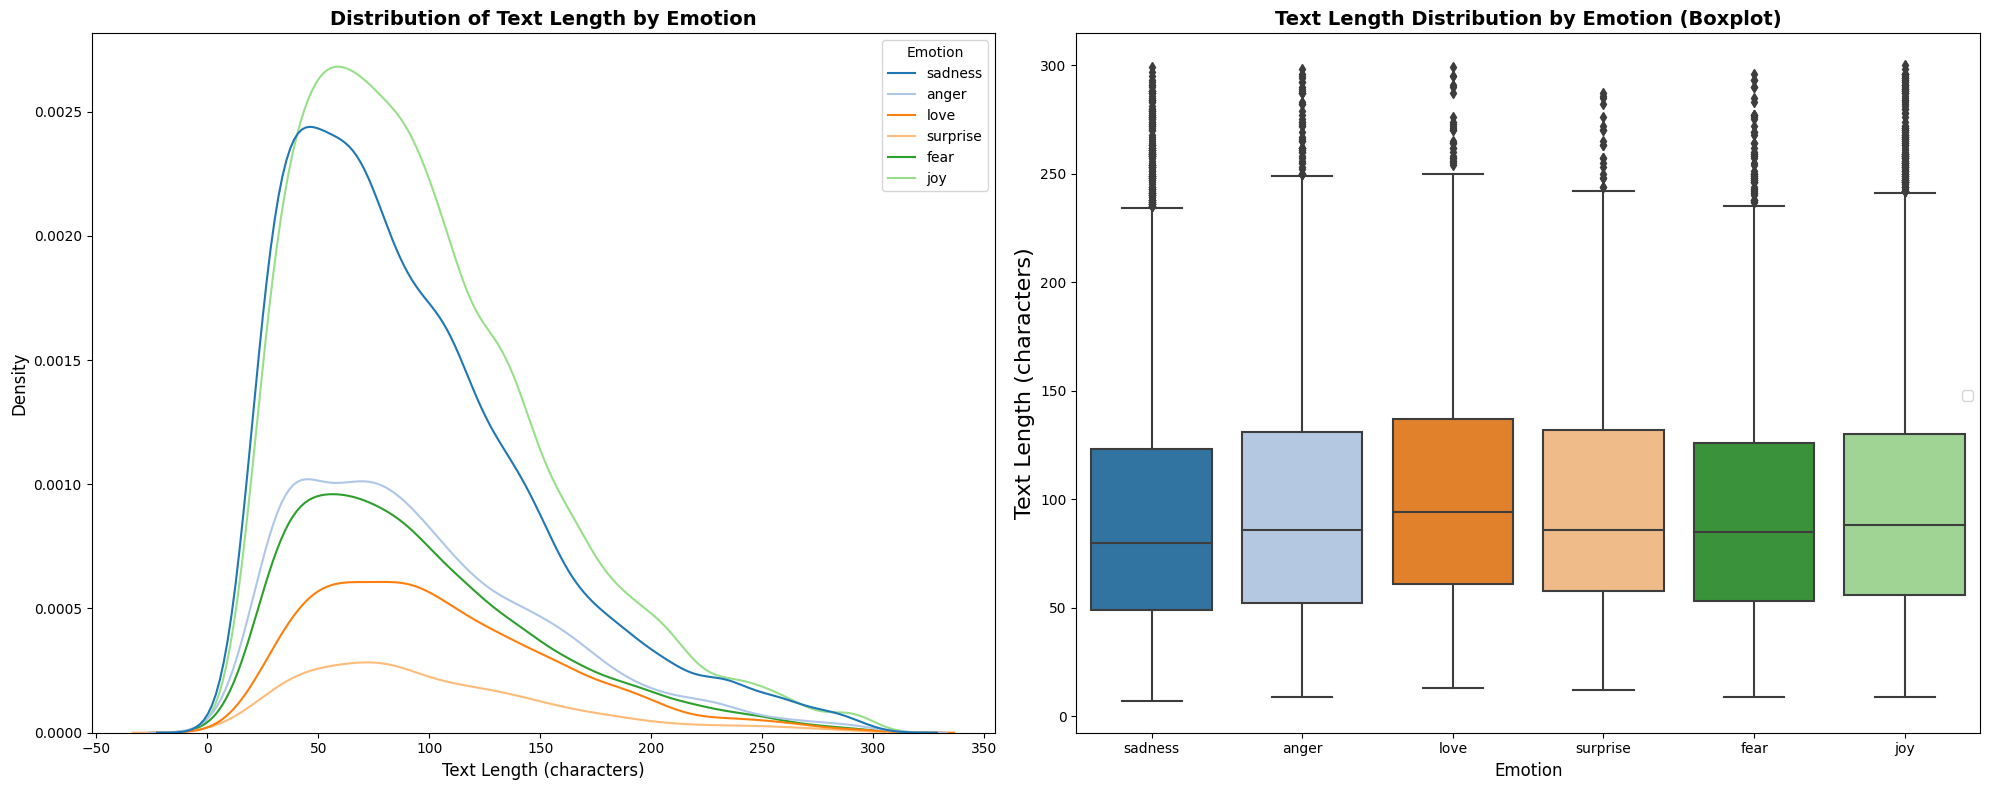

In [11]:
colors = sns.color_palette('tab20')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.kdeplot(x=data['len'], hue=data['Emotion'], ax=ax[0], palette=colors)

plt.legend(data['Emotion'].value_counts().index.tolist(), loc='upper right', bbox_to_anchor=(1, 0.5))

ax[0].set_title('Distribution of Text Length by Emotion', fontsize=14, weight='bold')
ax[0].set_xlabel('Text Length (characters)', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)

sns.boxplot(x=data['Emotion'], y=data['len'], ax=ax[1], palette=colors)
ax[1].set_title('Text Length Distribution by Emotion (Boxplot)', fontsize=14, weight='bold')
ax[1].set_xlabel('Emotion', fontsize=12)
ax[1].set_ylabel('Text Length (characters)', fontsize=16)


plt.tight_layout()
plt.show()

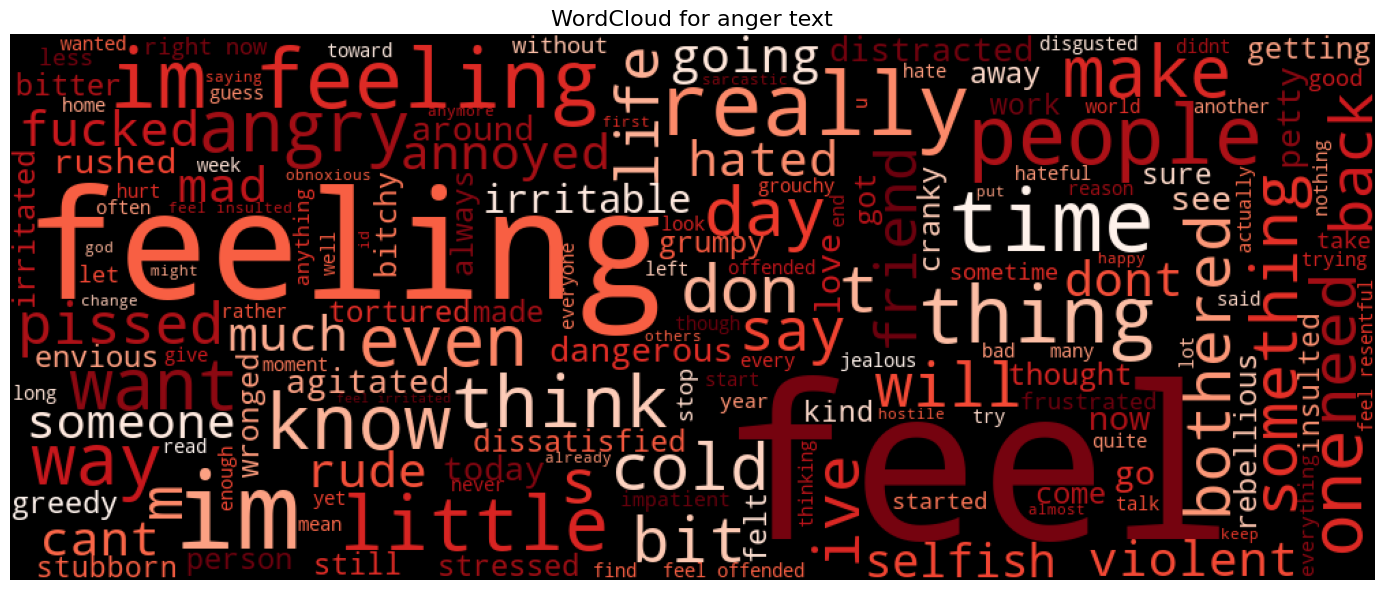

In [12]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 400, min_font_size = 10, background_color = 'black',colormap='Reds')
spam_wordcloud = wordcloud.generate(data[data['Emotion'] == 'anger']['Text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wordcloud)
plt.title('WordCloud for anger text', fontsize=16)

plt.axis('off')
plt.tight_layout()

plt.show()

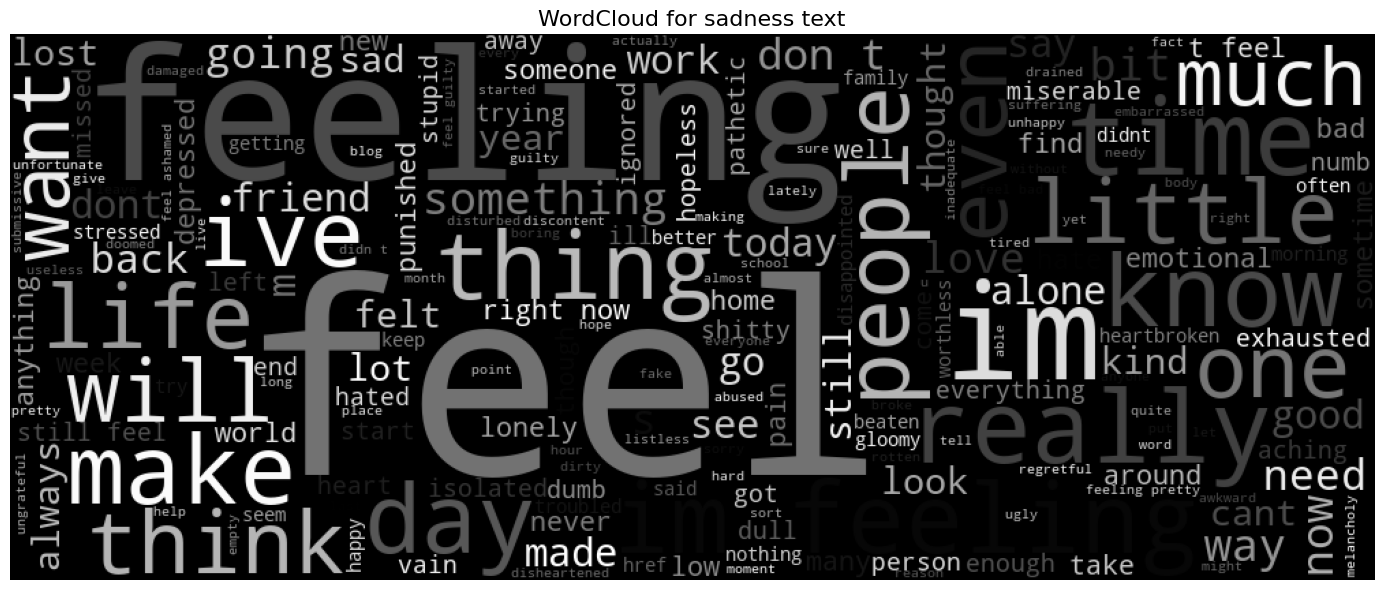

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 400, min_font_size = 10, background_color = 'black',colormap='Greys')
spam_wordcloud = wordcloud.generate(data[data['Emotion'] == 'sadness']['Text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wordcloud)
plt.title('WordCloud for sadness text', fontsize=16)

plt.axis('off')
plt.tight_layout()

plt.show()

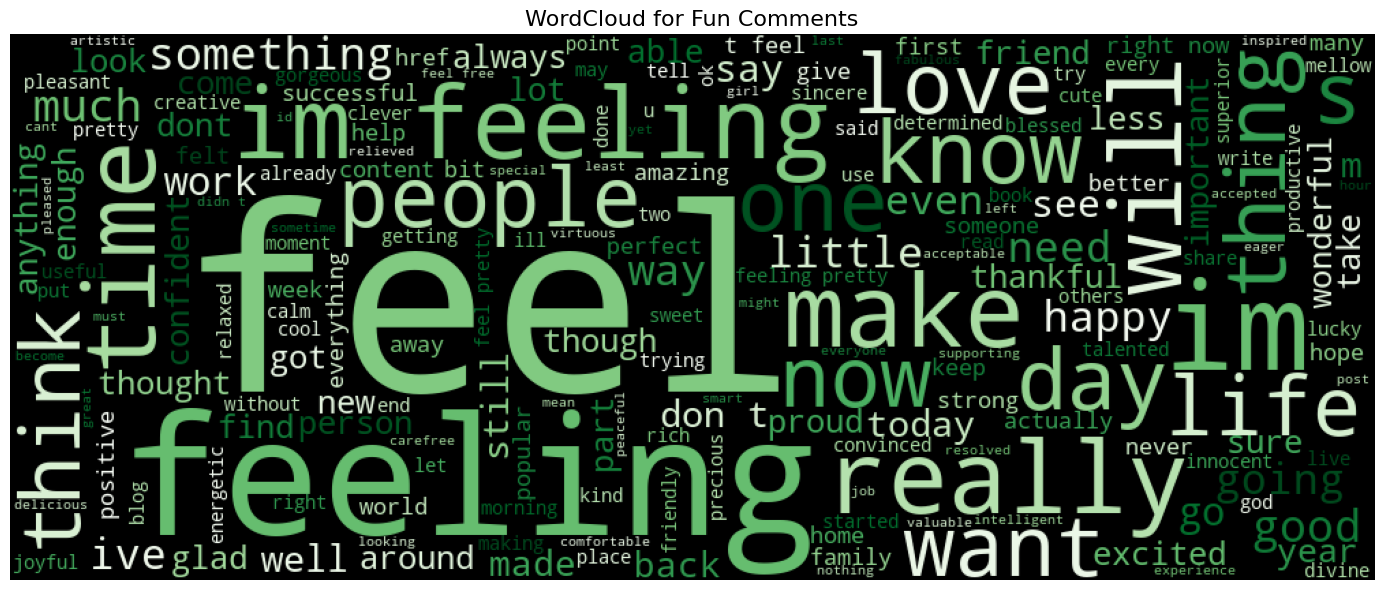

In [14]:
wordcloud = WordCloud(width = 1000, height = 400, min_font_size = 10, background_color = 'black',colormap='Greens')
fun_wordcloud = wordcloud.generate(data[data['Emotion'] == 'joy']['Text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(fun_wordcloud)
plt.title('WordCloud for Fun Comments', fontsize=16)

plt.axis('off')
plt.tight_layout()

# <a id="Import"></a>
# <p style="background-color: #FFE300; font-family: 'Copperplate'; color:#493323; font-size:140%; text-align:center; border-radius:1000px 10px;">Clean Text </p> 

In [15]:
#determine if there is same texts with different emotions
data[data.duplicated(subset=['Text'])]

,Text,Emotion,len
5067,i feel on the verge of tears from weariness i ...,joy,113
6133,i still feel a craving for sweet food,love,37
6563,i tend to stop breathing when i m feeling stre...,anger,50
7623,i was intensely conscious of how much cash i h...,sadness,183
7685,im still not sure why reilly feels the need to...,surprise,58
8246,i am not amazing or great at photography but i...,love,71
9596,ive also made it with both sugar measurements ...,joy,90
9687,i had to choose the sleek and smoother feel of...,joy,114
9769,i often find myself feeling assaulted by a mul...,sadness,73
9786,i feel im being generous with that statement,joy,44


In [16]:
data[data['Text']==data.iloc[15329]['Text']]

,Text,Emotion,len
2949,i shy away from songs that talk about how i fe...,love,121
15329,i shy away from songs that talk about how i fe...,joy,121


In [17]:
data.drop_duplicates(subset=['Text'],inplace=True)

In [18]:
data.reset_index(inplace=True,drop=True)

In [19]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before',  'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',  'each', 'most', 'other', 'some', 'such',  'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',]

In [21]:
lemmetizer=WordNetLemmatizer()
def clean_text (text):
  text=text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text=re.sub(r'\s+http\S+',' ',text)
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
  text = text.replace('؛',"", )
  text=re.sub(r'\s+',' ',text)
  text=text.strip()
#   words=word_tokenize(text)
  words = nlp(text)
  words = [word for word in words if word not in stopwords.words('english') and len(word) > 1]
#   words=[lemmetizer.lemmatize(word) for word in words]
  words = [word.lemma_ for word in words]
  return ' '.join(words)

In [22]:
data['Text']=data['Text'].apply(clean_text)

In [23]:
clean_text("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'my name be mohame tweets play 2022 egypt'

# <a id="Import"></a>
# <p style="background-color: #FFE300; font-family: 'Copperplate'; color:#493323; font-size:140%; text-align:center; border-radius:1000px 10px;"> Preparing for train </p> 

In [24]:
x=data['Text']
y=data['Emotion']

In [25]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x)
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=100)

In [26]:
tokenizer.texts_to_sequences(['i am happy'])

[[17, 2110, 133]]

In [27]:
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)
y=to_categorical(y)

In [28]:
y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [29]:
x_trian,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [30]:
x_trian=np.array(x_trian)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [31]:
vocab_size=len(tokenizer.word_index)+1
embedding_dim=100
max_length=max([len(t) for t in data['Text']])

# <a id="Import"></a>
# <p style="background-color: #FFE300; font-family: 'Copperplate'; color:#493323; font-size:140%; text-align:center; border-radius:1000px 10px;">Modeling </p> 

In [32]:
model=Sequential()
input=Input(shape=(max_length,))
model.add(input)
model.add(Embedding(vocab_size,200,input_length=max_length))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512, dropout=0.3,recurrent_dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(512,dropout=0.3,recurrent_dropout=0.2 ,return_sequences=True)))
model.add(Bidirectional(LSTM(512,dropout=0.3,recurrent_dropout=0.2 ,return_sequences=True)))
model.add(Bidirectional(LSTM(256,dropout=0.3,recurrent_dropout=0.2 ,return_sequences=True)))
model.add(Bidirectional(LSTM(256)))
# model.add(Dropout(0.3))
# model.add(Dense(512,activation='relu'))
model.add(Dense(6,activation='softmax'))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 287, 200)       │     2,697,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 287, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 287, 1024)      │     2,920,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 287, 1024)      │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 287, 1024)      │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 287, 512)       │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,410,630 (85.49 MB)

 Trainable params: 22,410,630 (85.49 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
adam=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [34]:
history=model.fit(x_trian,y_train,epochs=12,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3027s 12s/step - accuracy: 0.3679 - loss: 1.5628 - val_accuracy: 0.5995 - val_loss: 1.0856
Epoch 2/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3035s 12s/step - accuracy: 0.6261 - loss: 0.9912 - val_accuracy: 0.7168 - val_loss: 0.7364
Epoch 3/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3101s 12s/step - accuracy: 0.7347 - loss: 0.6722 - val_accuracy: 0.8003 - val_loss: 0.6191
Epoch 4/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3081s 12s/step - accuracy: 0.8301 - loss: 0.4868 - val_accuracy: 0.8925 - val_loss: 0.3476
Epoch 5/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3051s 12s/step - accuracy: 0.9064 - loss: 0.2923 - val_accuracy: 0.9208 - val_loss: 0.2528
Epoch 6/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3080s 12s/step - accuracy: 0.9313 - loss: 0.2087 - val_accuracy: 0.9281 - val_loss: 0.2236
Epoch 7/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3165s 13s/step - accuracy: 0.9418 - loss: 0.1667 - val_accuracy: 0.9296 - val_loss: 0.2032
Epoch 8/12
250/250 ━━━━━━━━━━━━━━━━━━━━ 3129s 13s/step - accuracy: 0.9517 - loss: 0

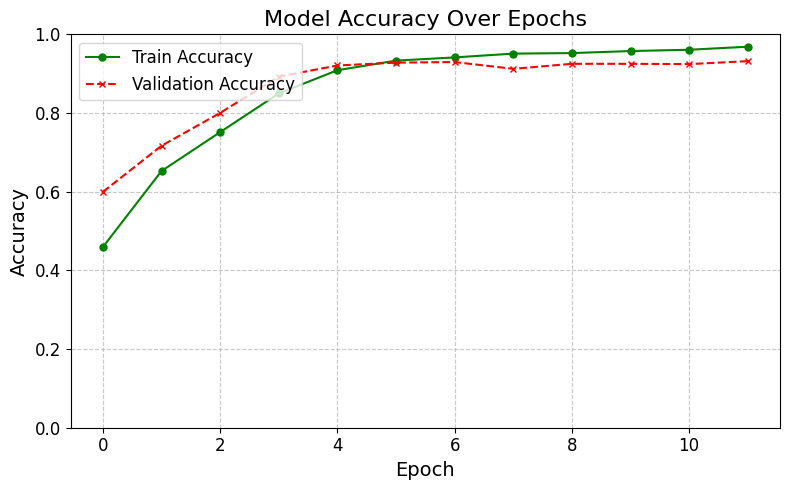

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


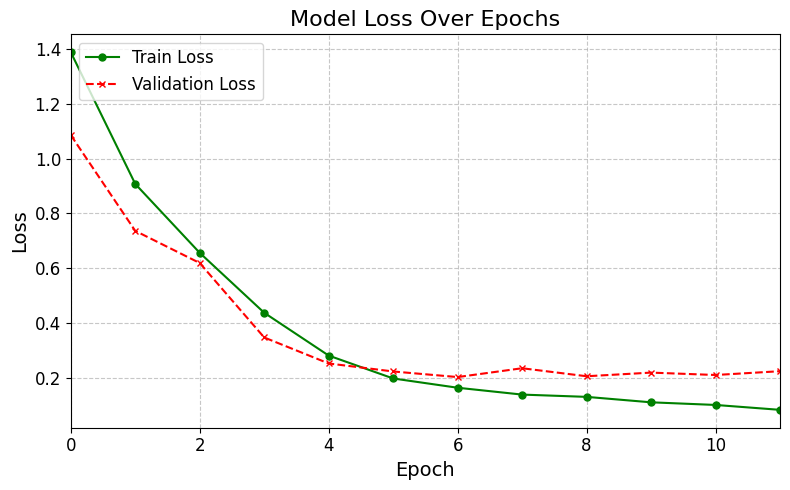

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()
